<a href="https://colab.research.google.com/github/siruku6/fx_notebooks/blob/master/220623_ml_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. モジュールの準備

In [1]:
!pip install -q pytorch_lightning torchinfo

     |████████████████████████████████| 585 kB 11.2 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 140 kB 65.1 MB/s 
     |████████████████████████████████| 419 kB 58.7 MB/s 
     |████████████████████████████████| 1.1 MB 28.1 MB/s 
     |████████████████████████████████| 144 kB 54.8 MB/s 
     |████████████████████████████████| 271 kB 55.9 MB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 


In [2]:
import os
from glob import glob
from typing import List

from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataset import Subset
import torchmetrics
from torchmetrics.functional import accuracy
import torchvision
from torchinfo import summary


# 2. データの準備


## 2-1. アップロード

In [ ]:
# Upload `chart_pngs.zip`
uploaded = files.upload()
!unzip chart_pngs.zip

In [4]:
# Upload `fx_train_test_data.cav`
uploaded = files.upload()

Saving fx_train_test_data.csv to fx_train_test_data.csv


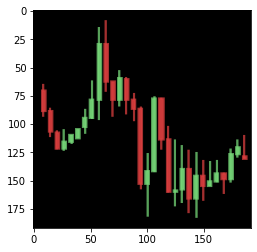

In [5]:
sample_image: str = './content/chart_pngs/sample_2511.png'
with open(sample_image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('RGB')

plt.imshow(image)
plt.show()

In [5]:
filenames: List[str] = glob('./content/chart_pngs/*')
len(filenames)

3833

In [6]:
df = pd.read_csv('./fx_train_test_data.csv')
print("Size of df", len(df))
df.head(10)


Size of df 3863


,low,open,high,close,time,close:lag+5,class
0,156.053,156.087,156.193,156.136,2021-10-31 21:00:00,156.134,0
1,156.088,156.117,156.240,156.226,2021-10-31 22:00:00,156.225,0
2,156.118,156.224,156.334,156.311,2021-10-31 23:00:00,156.238,0
3,155.922,156.314,156.338,155.992,2021-11-01 00:00:00,156.351,1
4,155.952,155.990,156.204,156.185,2021-11-01 01:00:00,156.274,0
5,156.042,156.183,156.183,156.134,2021-11-01 02:00:00,156.197,0
6,156.129,156.136,156.298,156.225,2021-11-01 03:00:00,156.016,0
7,156.204,156.222,156.322,156.238,2021-11-01 04:00:00,156.024,0
8,156.236,156.240,156.448,156.351,2021-11-01 05:00:00,155.991,2
9,156.210,156.353,156.389,156.274,2021-11-01 06:00:00,156.235,0


In [7]:
# 末尾30行を削除
print("Size of images:", len(filenames))
print("Size of df: ", len(df))

Size of images: 3833
Size of df:  3863


1枚の画像を作るのに30行必要なので、画像の方が、データ30行分少ない

そのため、後で学習データを作成する時は、csvの末尾30行を無視してデータを作成する

In [24]:
# こんな感じでOK
df[['class']][:-30].to_numpy()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [55]:
print("Size of df: ", len(df[['class']][:-30]))

Size of df:  3833


## 2-2. DataLoaderの作成

In [8]:
os.listdir('./content/chart_pngs')[:4]

['sample_3242.png', 'sample_3313.png', 'sample_796.png', 'sample_3001.png']

In [9]:
filenames = sorted(os.listdir('./content/chart_pngs'))
filenames[:4]

['sample_0.png', 'sample_1.png', 'sample_10.png', 'sample_100.png']

In [10]:
# 元の並び順も、sorted実行後も画像の順番が時系列順にならないので、自分でファイル名配列を作る
filenames = [f'sample_{index}.png' for index in range(0, 3634)]
filenames[:10]

['sample_0.png',
 'sample_1.png',
 'sample_2.png',
 'sample_3.png',
 'sample_4.png',
 'sample_5.png',
 'sample_6.png',
 'sample_7.png',
 'sample_8.png',
 'sample_9.png']

In [11]:
# Dataset作成
class ChartDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.images: List[str] = [f'sample_{index}.png' for index in range(0, 3634)]

        # 末尾30行を無視
        df_chart: pd.DataFrame = pd.read_csv('./fx_train_test_data.csv')[:-30]
        self.labels = df_chart['class'].to_numpy()

    def __getitem__(self, index: int):
        image: str = self.images[index]
        label: np.ndarray = self.labels[index]

        with open(f'./content/chart_pngs/{image}', 'rb') as f:
            image = Image.open(f).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)


In [25]:
# seed 固定
pl.seed_everything(0)

# Dataset初期化
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
chart_dataset: ChartDataset = ChartDataset(transform=transforms)

n_train: int = int(len(chart_dataset) * 0.6)
n_val: int = int(len(chart_dataset) * 0.2)
n_test: int = len(chart_dataset) - n_train - n_val

train_indices: List[int] = list(range(0, n_train))
val_indices: List[int] = list(range(n_train, n_train + n_val))
test_indices: List[int] = list(range(n_train + n_val, len(chart_dataset)))

# NOTE: Subset をつかうと randomではない分割が可能
# https://qiita.com/takurooo/items/ba8c509eaab080e2752c#%E8%A7%A3%E6%B1%BA%E7%AD%961-torchutilsdatasubset
# FXは過去のデータから未来の予測をしたいので、学習データは過去データ。
# validation, testデータは未来のデータ、という分け方にしたい。
train = Subset(chart_dataset, train_indices)
val = Subset(chart_dataset, val_indices)
test = Subset(chart_dataset, test_indices)

# DataLoader作成
batch_size = 50
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

Global seed set to 0


[0 0 0 1 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 1 2 0 0 0 1 2 1 0]


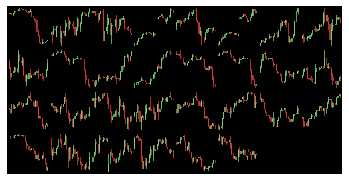

In [13]:
# DataLoaderの動作確認
def show_sample_images(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2 ,0)), interpolation='nearest')

for _, (images, labels) in enumerate(train_loader):
    print(labels.numpy())
    show_sample_images(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    break


# 3. 学習

## 3-1. 学習ネットワーク実装

In [14]:
# 画像入力サイズの確認
image, label = next(iter(train_loader))
image.shape

torch.Size([30, 3, 192, 192])

In [15]:
# 1 layerずつ動作確認

conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
dropout1 = nn.Dropout2d(p=0.25)
conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
dropout2 = nn.Dropout2d(p=0.25)

fc1 = nn.Linear(13824, 256)
dropout3 = nn.Dropout(p=0.5)
fc2 = nn.Linear(256, 3)


h = conv1(image)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)

h = conv2(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)
h = dropout1(h)

h = conv3(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)

h = conv4(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)
h = dropout2(h)
# h.shape -> torch.Size([30, 96, 12, 12])
# 96 * 12 * 12 -> 13824

h = h.view(-1, 13824)  # ベクトル化

h = fc1(h)
h = F.relu(h)
h = dropout3(h)
y = fc2(h)
y.shape

# 動いた

torch.Size([30, 3])

In [71]:
label

tensor([2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 2])

In [72]:
F.cross_entropy(y, label)

tensor(1.0943, grad_fn=<NllLossBackward0>)

In [28]:
class Network(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)
        h = self.fc2(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.SGD(params=self.parameters(), lr=0.001)
        # return optimizer
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.1, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer, ], [scheduler, ]

In [74]:
# アーキテクチャの確認
net = Network()  # .cuda()
summary(net, input_size=(3, 192, 192))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 3]                    --
├─Conv2d: 1-1                            [32, 192, 192]            896
├─Conv2d: 1-2                            [48, 96, 96]              13,872
├─Dropout2d: 1-3                         [48, 48, 48]              --
├─Conv2d: 1-4                            [64, 48, 48]              27,712
├─Conv2d: 1-5                            [96, 24, 24]              55,392
├─Dropout2d: 1-6                         [96, 12, 12]              --
├─Linear: 1-7                            [1, 256]                  3,539,200
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 3]                    771
Total params: 3,637,843
Trainable params: 3,637,843
Non-trainable params: 0
Total mult-adds (M): 285.72
Input size (MB): 0.44
Forward/backward pass size (MB): 14.60
Params size (MB): 14.55
Estimated Total

結構ネットワーク大きい

画像サイズ減らしても精度落ちないのであれば減らしたい

## 3-2. training / validation

In [17]:
# gpu有効なら実行しておく
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

if torch.cuda.is_available():
    import psutil
    import humanize
    import os
    import GPUtil as GPU

    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=787c5521580014cc863ef1d834f57ee4e5f3de0b4d7fce6bbade68f6a907950e
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.1 GB  |     Proc size: 904.8 MB
GPU RAM Free: 15106MB | Used: 3MB | Util   0% | Total     15109MB


In [29]:
# 学習
pl.seed_everything(0)
net = Network()

log_dir: str = 'fx_trader'
logger = CSVLogger(save_dir='logs', name=log_dir)
trainer = pl.Trainer(max_epochs=50, gpus=1, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)
trainer.callback_metrics

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 13.9 K
2 | dropout1 | Dropout2d | 0     
3 | conv3    | Conv2d    | 27.7 K
4 | conv4    | Conv2d    | 55.4 K
5 | dropout2 | Dropout2d | 0     
6 | fc1      | Linear    | 3.5 M 
7 | dropout3 | Dropout   | 0     
8 | fc2      | Linear    | 771   
---------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.551    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'train_acc': tensor(0.9265),
 'train_acc_epoch': tensor(0.9265),
 'train_acc_step': tensor(0.8800),
 'train_loss': tensor(0.1694),
 'train_loss_epoch': tensor(0.1694),
 'train_loss_step': tensor(0.2670),
 'val_acc': tensor(0.7961),
 'val_loss': tensor(0.6927)}

## 3-3. test

In [30]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/fx_trader/version_3/checkpoints/epoch=49-step=2150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/fx_trader/version_3/checkpoints/epoch=49-step=2150.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7403846383094788
        test_loss           1.0602726936340332
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7403846383094788, 'test_loss': 1.0602726936340332}]

## 3-4. Display result

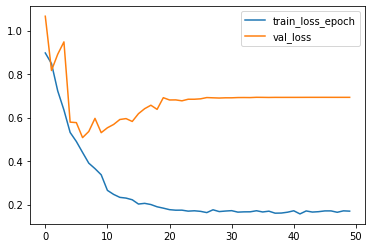

In [32]:
# 結果確認
log = pd.read_csv(f'logs/{log_dir}/version_3/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

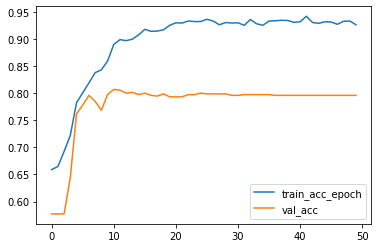

In [33]:
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()


30epochで十分そうだ...

しかも10epoch過ぎた時点で既に過学習の兆候が見えている


# 4. その他 / 考察

In [38]:
df_chart = pd.read_csv('./fx_train_test_data.csv')[:-30]
df_chart.groupby(['class'])['class'].count()

class
0    2287
1     848
2     698
Name: class, dtype: int64

- classごとのデータ数はそこまで大幅に偏っているわけではない
- 今回は足5本先の時点で20pips変動があるかどうかを判定したが、もう少し厳しい条件にした場合などで、精度がどう変わるか見てみてもよいかもしれない
- たとえば、一時的なドローダウンが間に挟まっている場合はトレードしない方が良いので、class: 0（変動なし）扱いにした場合、精度がどう変わるかは気になる